In [2]:
import matplotlib.pyplot as plt
import numpy as np

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



# wfs_unmod = TR_Pyramid(nSubap=param['nSubaperture'], \
#                  telescope=tel, \
#                  modulation=0, \
#                  lightRatio=param['lightThreshold'], \
#                  n_pix_separation=4,
#                  calibModulation=param['calibrationModulation'], \
#                  psfCentering=param['psfCentering'], \
#                  n_pix_edge=2,
#                  extraModulationFactor=param['extraModulationFactor'], \
#                  postProcessing=param['postProcessing'],
#                  nTheta_user_defined = param['nTheta_user_defined'])



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


**************************************************************************************************************************************************************
NUMPY WARNING: mkl blas not found! Multi-threading may not work as expected.
**************************************************************************************************************************************************************
Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             24               [m]        
    Resolution           120             [pixels]     
    Pixel Size        

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


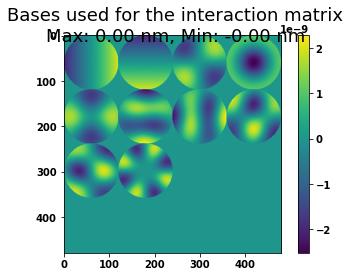

In [3]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


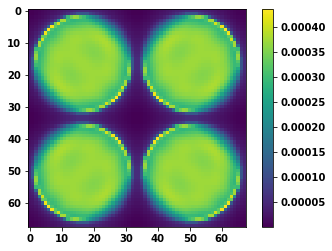

In [4]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


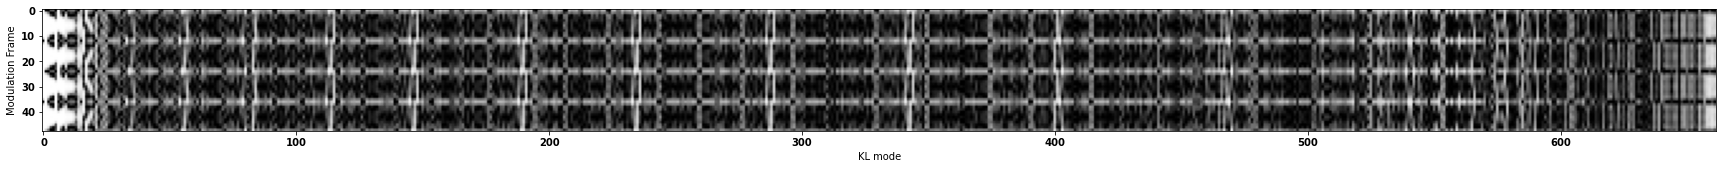

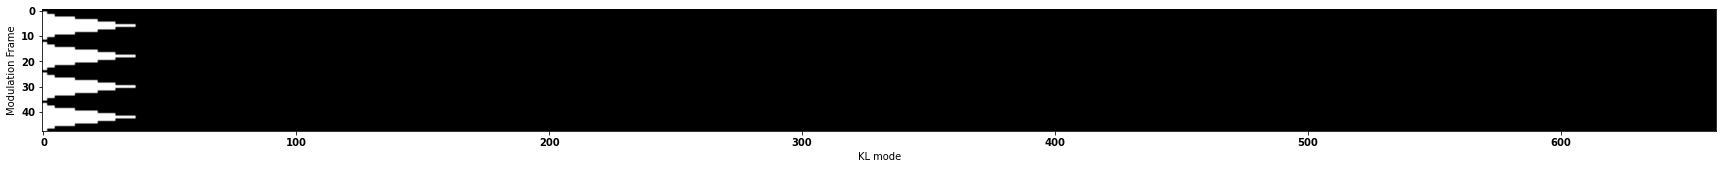

In [5]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]
#ref_cube_c = np.zeros((ref_cube.shape[0], nModes))
#push_cube_c = np.zeros((ref_cube.shape[0], nModes))
#pull_cube_c = np.zeros((ref_cube.shape[0], nModes))
#to_cov = np.zeros(())
# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):

    #t = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))
    #ref_cube_c[:,i] = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))/stroke
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    #push_cube_c[:,i] = np.sqrt(np.mean((push/np.sum(push))**2, axis=1))/stroke
    if i == 0:
        push_cube_c = np.mean(push_signal, axis=1)/stroke

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)
    if i == 0:
        pull_cube_c = np.mean(pull_signal, axis=1)/stroke

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)



weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    avg_val = np.mean(i_cube[:, :, i])
    #avg_val = 0
    weighting_cube[:,i] = ((np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))**2
    #weighting_cube[:,i] = -(weighting_cube[:,i] - np.mean(weighting_cube[:,i]))
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(np.abs(weighting_cube[:,i]))

    #weighting_cube[:,i] = np.arctan(weighting_cube[:,i])

plt.figure(figsize=(30,20))
im1 = plt.imshow(weighting_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")



framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0

plt.figure(figsize=(30,20))
im2 = plt.imshow(binary_weight_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

In [6]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, wfs.validSignal]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, wfs.validSignal]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[wfs.validSignal]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[wfs.validSignal]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)


        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


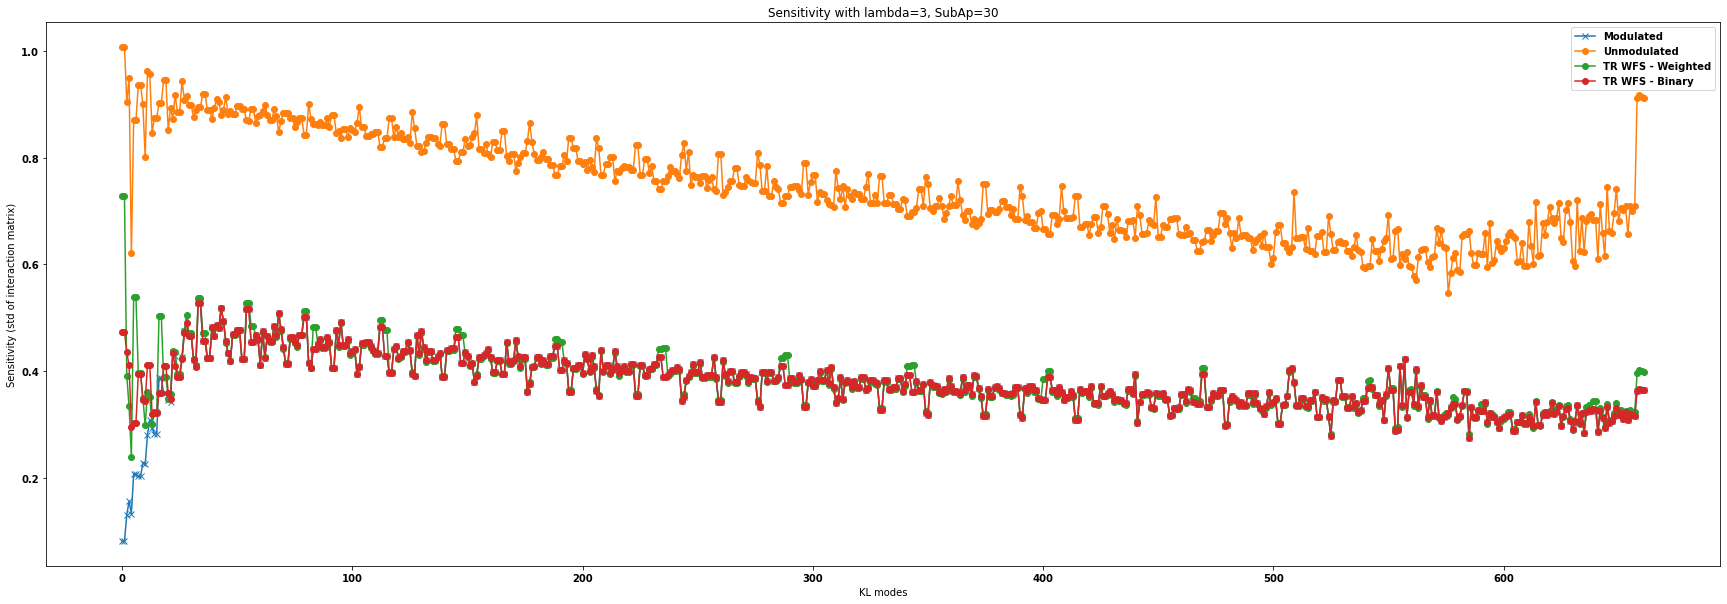

In [7]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure(figsize=(30,10))
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0)) / radian_in_1m, marker="x",label="Modulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated - np.mean(I_mat_modulated, axis=0) )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}, SubAp={wfs.nSubap}")
plt.legend()

%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Source Wavelength Zenith  Azimuth   Altitude Magnitude    Flux   
           [m]    [arcsec]  [deg]      [m]              [phot/m2/s]
-------------------------------------------------------------------
  NGS    7.9e-07     0        0        inf    12.000000000000002 116282.9 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Telescope and Atmosphere combined!


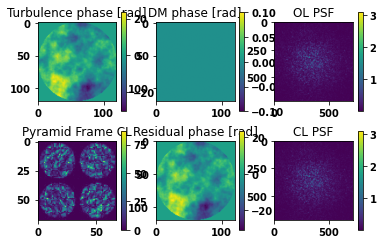

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_weighted_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =100
plt.close('all')

ngs = Source(optBand=param['opticalBand'], \
             magnitude=12.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
#wfsSignal               = np.arange(0,wfs.nSignal)*0
wfsSignal = np.zeros(wfs.pyramidSignalCube.shape)
a_est = np.zeros((M2C_CL.shape[1]))
# loop parameters
gainCL                  = 0.4
wfs.cam.photonNoise     = True
display                 = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    
    for j_mode in range(len(a_est)):
        t_signal = wfs.cam.cube[:, wfs.validSignal]
        t_t_signal = np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode]) - \
                      np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode])
        #weighted_signal = wfsSignal * self.weightsPerFramePerMode[j_mode, :, np.newaxis]
        a_est[j_mode] = ( calib_CL @ t_t_signal)[j_mode]

    correction = np.matmul(M2C_CL, a_est)
    
    dm.coefs=dm.coefs - gainCL*correction
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal = wfs.pyramidSignalCube
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    #print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')


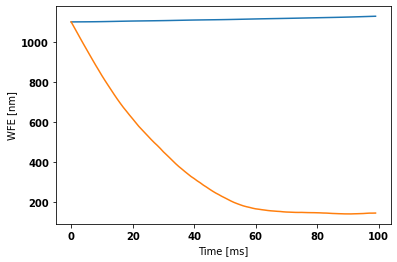

In [9]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)


Telescope and Atmosphere combined!


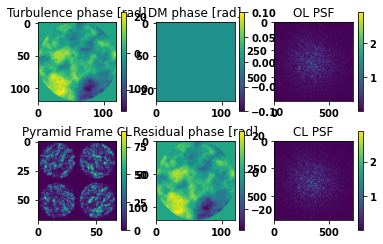

Elapsed time: 0.2876746654510498 s


<Figure size 432x288 with 0 Axes>

Loop0/100 Turbulence: 1127.2014181594493 -- Residual:1127.2014181594493
Elapsed time: 0.3413665294647217 s


<Figure size 432x288 with 0 Axes>

Loop1/100 Turbulence: 1127.605144895761 -- Residual:1127.605144895761
Elapsed time: 0.32262468338012695 s


<Figure size 432x288 with 0 Axes>

Loop2/100 Turbulence: 1127.9967012716224 -- Residual:1047.725211920971
Elapsed time: 0.27277255058288574 s


<Figure size 432x288 with 0 Axes>

Loop3/100 Turbulence: 1128.374564832752 -- Residual:967.1865499127583
Elapsed time: 0.3687760829925537 s


<Figure size 432x288 with 0 Axes>

Loop4/100 Turbulence: 1128.7128362425233 -- Residual:887.0527831357214
Elapsed time: 0.30207014083862305 s


<Figure size 432x288 with 0 Axes>

Loop5/100 Turbulence: 1129.0763526734909 -- Residual:806.8514008709278
Elapsed time: 0.3901951313018799 s


<Figure size 432x288 with 0 Axes>

Loop6/100 Turbulence: 1129.442402293908 -- Residual:732.3922055839132
Elapsed time: 0.28106069564819336 s


<Figure size 432x288 with 0 Axes>

Loop7/100 Turbulence: 1129.8172063426377 -- Residual:658.6898245806017
Elapsed time: 0.31035590171813965 s


<Figure size 432x288 with 0 Axes>

Loop8/100 Turbulence: 1130.2061017121832 -- Residual:586.1617232882701
Elapsed time: 0.2673146724700928 s


<Figure size 432x288 with 0 Axes>

Loop9/100 Turbulence: 1130.6133889212695 -- Residual:512.4917781879345
Elapsed time: 0.36507678031921387 s


<Figure size 432x288 with 0 Axes>

Loop10/100 Turbulence: 1131.0421835621023 -- Residual:445.49534083458406
Elapsed time: 0.3153226375579834 s


<Figure size 432x288 with 0 Axes>

Loop11/100 Turbulence: 1131.4943752960423 -- Residual:385.7543914871831
Elapsed time: 0.3521842956542969 s


<Figure size 432x288 with 0 Axes>

Loop12/100 Turbulence: 1131.9705760124302 -- Residual:334.981790317274
Elapsed time: 0.26898193359375 s


<Figure size 432x288 with 0 Axes>

Loop13/100 Turbulence: 1132.4701029344787 -- Residual:295.98510752120757
Elapsed time: 0.366497278213501 s


<Figure size 432x288 with 0 Axes>

Loop14/100 Turbulence: 1132.9910841971916 -- Residual:263.6226317705624
Elapsed time: 0.29342079162597656 s


<Figure size 432x288 with 0 Axes>

Loop15/100 Turbulence: 1133.5300875681512 -- Residual:236.00335458796891
Elapsed time: 0.3738858699798584 s


<Figure size 432x288 with 0 Axes>

Loop16/100 Turbulence: 1134.082586728044 -- Residual:210.53649496609324
Elapsed time: 0.32877659797668457 s


<Figure size 432x288 with 0 Axes>

Loop17/100 Turbulence: 1134.644056422967 -- Residual:193.6660093500563
Elapsed time: 0.42560338973999023 s


<Figure size 432x288 with 0 Axes>

Loop18/100 Turbulence: 1135.2081751574935 -- Residual:180.37706802432731
Elapsed time: 0.3289375305175781 s


<Figure size 432x288 with 0 Axes>

Loop19/100 Turbulence: 1135.7659708409706 -- Residual:168.58237371906753
Elapsed time: 0.29050445556640625 s


<Figure size 432x288 with 0 Axes>

Loop20/100 Turbulence: 1136.3152524425552 -- Residual:160.6846119853913
Elapsed time: 0.37703418731689453 s


<Figure size 432x288 with 0 Axes>

Loop21/100 Turbulence: 1136.8518384879665 -- Residual:155.5687000954888
Elapsed time: 0.3454701900482178 s


<Figure size 432x288 with 0 Axes>

Loop22/100 Turbulence: 1137.3897387785003 -- Residual:152.86786268789356
Elapsed time: 0.46133995056152344 s


<Figure size 432x288 with 0 Axes>

Loop23/100 Turbulence: 1137.9040031772884 -- Residual:151.16454483733781
Elapsed time: 0.3012969493865967 s


<Figure size 432x288 with 0 Axes>

Loop24/100 Turbulence: 1138.3972226176586 -- Residual:149.82146777503175
Elapsed time: 0.45307159423828125 s


<Figure size 432x288 with 0 Axes>

Loop25/100 Turbulence: 1138.8213556644614 -- Residual:148.68002558664048
Elapsed time: 0.27132153511047363 s


<Figure size 432x288 with 0 Axes>

Loop26/100 Turbulence: 1139.284196774614 -- Residual:147.67411846817376
Elapsed time: 0.36519527435302734 s


<Figure size 432x288 with 0 Axes>

Loop27/100 Turbulence: 1139.737469105175 -- Residual:146.72174006472522
Elapsed time: 0.36892008781433105 s


<Figure size 432x288 with 0 Axes>

Loop28/100 Turbulence: 1140.1836383064458 -- Residual:146.40089128026418
Elapsed time: 0.35288214683532715 s


<Figure size 432x288 with 0 Axes>

Loop29/100 Turbulence: 1140.637835372269 -- Residual:145.8354727100392
Elapsed time: 0.4402501583099365 s


<Figure size 432x288 with 0 Axes>

Loop30/100 Turbulence: 1141.0979332971735 -- Residual:144.98849313174117
Elapsed time: 0.3045203685760498 s


<Figure size 432x288 with 0 Axes>

Loop31/100 Turbulence: 1141.5675393584916 -- Residual:144.68229677987483
Elapsed time: 0.39404797554016113 s


<Figure size 432x288 with 0 Axes>

Loop32/100 Turbulence: 1142.0484814117835 -- Residual:144.56879865780886
Elapsed time: 0.30074644088745117 s


<Figure size 432x288 with 0 Axes>

Loop33/100 Turbulence: 1142.5425136020847 -- Residual:144.62659508697038
Elapsed time: 0.3671081066131592 s


<Figure size 432x288 with 0 Axes>

Loop34/100 Turbulence: 1143.0493189023973 -- Residual:144.453649299698
Elapsed time: 0.456989049911499 s


<Figure size 432x288 with 0 Axes>

Loop35/100 Turbulence: 1143.607292985861 -- Residual:144.5940957023458
Elapsed time: 0.3584015369415283 s


<Figure size 432x288 with 0 Axes>

Loop36/100 Turbulence: 1144.141761594917 -- Residual:144.82577317851832
Elapsed time: 0.45479917526245117 s


<Figure size 432x288 with 0 Axes>

Loop37/100 Turbulence: 1144.6829436755786 -- Residual:145.79444165013345
Elapsed time: 0.42111635208129883 s


<Figure size 432x288 with 0 Axes>

Loop38/100 Turbulence: 1145.2264587613372 -- Residual:146.23053401459032
Elapsed time: 0.4530143737792969 s


<Figure size 432x288 with 0 Axes>

Loop39/100 Turbulence: 1145.7668990930397 -- Residual:147.5956768093362
Elapsed time: 0.4680776596069336 s


<Figure size 432x288 with 0 Axes>

Loop40/100 Turbulence: 1146.302500836077 -- Residual:148.3879518119458
Elapsed time: 0.30437445640563965 s


<Figure size 432x288 with 0 Axes>

Loop41/100 Turbulence: 1146.830766114552 -- Residual:149.01922662293305
Elapsed time: 0.3575925827026367 s


<Figure size 432x288 with 0 Axes>

Loop42/100 Turbulence: 1147.349461717958 -- Residual:149.65352848687868
Elapsed time: 0.3368949890136719 s


<Figure size 432x288 with 0 Axes>

Loop43/100 Turbulence: 1147.8556026977558 -- Residual:148.94966899425918
Elapsed time: 0.4372556209564209 s


<Figure size 432x288 with 0 Axes>

Loop44/100 Turbulence: 1148.3459809174662 -- Residual:149.32962828303002
Elapsed time: 0.28933024406433105 s


<Figure size 432x288 with 0 Axes>

Loop45/100 Turbulence: 1148.8170668076077 -- Residual:149.53691858901564
Elapsed time: 0.3679850101470947 s


<Figure size 432x288 with 0 Axes>

Loop46/100 Turbulence: 1149.2692295117668 -- Residual:149.72725540825186
Elapsed time: 0.32341456413269043 s


<Figure size 432x288 with 0 Axes>

Loop47/100 Turbulence: 1149.7057318838856 -- Residual:148.7760904680427
Elapsed time: 0.36726808547973633 s


<Figure size 432x288 with 0 Axes>

Loop48/100 Turbulence: 1150.1467760205953 -- Residual:148.0268862265456
Elapsed time: 0.2863466739654541 s


<Figure size 432x288 with 0 Axes>

Loop49/100 Turbulence: 1150.583692817667 -- Residual:147.44786192743294
Elapsed time: 0.4121534824371338 s


<Figure size 432x288 with 0 Axes>

Loop50/100 Turbulence: 1151.0218389412662 -- Residual:146.16093985792367
Elapsed time: 0.3355674743652344 s


<Figure size 432x288 with 0 Axes>

Loop51/100 Turbulence: 1151.4654395311422 -- Residual:144.81657480330855
Elapsed time: 0.36321115493774414 s


<Figure size 432x288 with 0 Axes>

Loop52/100 Turbulence: 1151.9176077962386 -- Residual:144.21844129948337
Elapsed time: 0.32628560066223145 s


<Figure size 432x288 with 0 Axes>

Loop53/100 Turbulence: 1152.3800864486548 -- Residual:144.2499396082012
Elapsed time: 0.427459716796875 s


<Figure size 432x288 with 0 Axes>

Loop54/100 Turbulence: 1152.8542538682555 -- Residual:143.72054467363495
Elapsed time: 0.32060837745666504 s


<Figure size 432x288 with 0 Axes>

Loop55/100 Turbulence: 1153.340078655606 -- Residual:142.89550428549552
Elapsed time: 0.3412628173828125 s


<Figure size 432x288 with 0 Axes>

Loop56/100 Turbulence: 1153.836484088084 -- Residual:142.65081624279773
Elapsed time: 0.3314545154571533 s


<Figure size 432x288 with 0 Axes>

Loop57/100 Turbulence: 1154.3415344892524 -- Residual:143.1580014374302
Elapsed time: 0.34773826599121094 s


<Figure size 432x288 with 0 Axes>

Loop58/100 Turbulence: 1154.8524573330672 -- Residual:144.4345515333832
Elapsed time: 0.37930774688720703 s


<Figure size 432x288 with 0 Axes>

Loop59/100 Turbulence: 1155.3640029364733 -- Residual:145.11966059919058
Elapsed time: 0.2952547073364258 s


<Figure size 432x288 with 0 Axes>

Loop60/100 Turbulence: 1155.8777018183455 -- Residual:144.8427941296101
Elapsed time: 0.3294086456298828 s


<Figure size 432x288 with 0 Axes>

Loop61/100 Turbulence: 1156.3924326901417 -- Residual:145.5389023632674
Elapsed time: 0.29770874977111816 s


<Figure size 432x288 with 0 Axes>

Loop62/100 Turbulence: 1156.9063179569216 -- Residual:145.48093294013046
Elapsed time: 0.3498570919036865 s


<Figure size 432x288 with 0 Axes>

Loop63/100 Turbulence: 1157.4168377976637 -- Residual:146.2109008308414
Elapsed time: 0.3494284152984619 s


<Figure size 432x288 with 0 Axes>

Loop64/100 Turbulence: 1157.9205202744072 -- Residual:147.21993398571064
Elapsed time: 0.394686222076416 s


<Figure size 432x288 with 0 Axes>

Loop65/100 Turbulence: 1158.4131709664036 -- Residual:148.13772086277518
Elapsed time: 0.31048083305358887 s


<Figure size 432x288 with 0 Axes>

Loop66/100 Turbulence: 1158.8899353710144 -- Residual:148.17378517732845
Elapsed time: 0.432725191116333 s


<Figure size 432x288 with 0 Axes>

Loop67/100 Turbulence: 1159.3319291130215 -- Residual:148.12580734693177
Elapsed time: 0.30780911445617676 s


<Figure size 432x288 with 0 Axes>

Loop68/100 Turbulence: 1159.7714926411415 -- Residual:148.46144911278034
Elapsed time: 0.4486358165740967 s


<Figure size 432x288 with 0 Axes>

Loop69/100 Turbulence: 1160.1253387197796 -- Residual:148.24204878027203
Elapsed time: 0.32170653343200684 s


<Figure size 432x288 with 0 Axes>

Loop70/100 Turbulence: 1160.5266502489155 -- Residual:148.2483624740097
Elapsed time: 0.4259507656097412 s


<Figure size 432x288 with 0 Axes>

Loop71/100 Turbulence: 1160.9106612530368 -- Residual:148.53046498077862
Elapsed time: 0.5139963626861572 s


<Figure size 432x288 with 0 Axes>

Loop72/100 Turbulence: 1161.2932443150917 -- Residual:148.86615781754355
Elapsed time: 0.2706446647644043 s


<Figure size 432x288 with 0 Axes>

Loop73/100 Turbulence: 1161.6660492342182 -- Residual:148.68753822988313
Elapsed time: 0.35863780975341797 s


<Figure size 432x288 with 0 Axes>

Loop74/100 Turbulence: 1162.0326959337588 -- Residual:149.41297782590092
Elapsed time: 0.32276344299316406 s


<Figure size 432x288 with 0 Axes>

Loop75/100 Turbulence: 1162.397231679834 -- Residual:149.07790671393633
Elapsed time: 0.43749022483825684 s


<Figure size 432x288 with 0 Axes>

Loop76/100 Turbulence: 1162.76298054562 -- Residual:148.48541394295847
Elapsed time: 0.4124643802642822 s


<Figure size 432x288 with 0 Axes>

Loop77/100 Turbulence: 1163.132076334435 -- Residual:149.64543060778496
Elapsed time: 0.2889242172241211 s


<Figure size 432x288 with 0 Axes>

Loop78/100 Turbulence: 1163.5054071133452 -- Residual:150.19170965375255
Elapsed time: 0.3075416088104248 s


<Figure size 432x288 with 0 Axes>

Loop79/100 Turbulence: 1163.885701539371 -- Residual:149.24391321840847
Elapsed time: 0.30992579460144043 s


<Figure size 432x288 with 0 Axes>

Loop80/100 Turbulence: 1164.2732539303424 -- Residual:147.92600781838482
Elapsed time: 0.3191812038421631 s


<Figure size 432x288 with 0 Axes>

Loop81/100 Turbulence: 1164.6703298133998 -- Residual:146.1165292909287
Elapsed time: 0.31064438819885254 s


<Figure size 432x288 with 0 Axes>

Loop82/100 Turbulence: 1165.078105917 -- Residual:146.08321992084797
Elapsed time: 0.346970796585083 s


<Figure size 432x288 with 0 Axes>

Loop83/100 Turbulence: 1165.4961701324578 -- Residual:146.12001346367907
Elapsed time: 0.2827486991882324 s


<Figure size 432x288 with 0 Axes>

Loop84/100 Turbulence: 1165.9236910553002 -- Residual:146.5097182928998
Elapsed time: 0.3574542999267578 s


<Figure size 432x288 with 0 Axes>

Loop85/100 Turbulence: 1166.358813313609 -- Residual:147.1616840991479
Elapsed time: 0.33441805839538574 s


<Figure size 432x288 with 0 Axes>

Loop86/100 Turbulence: 1166.798793970053 -- Residual:146.8321409693228
Elapsed time: 0.3471817970275879 s


<Figure size 432x288 with 0 Axes>

Loop87/100 Turbulence: 1167.2400243944237 -- Residual:146.4033373397826
Elapsed time: 0.41014909744262695 s


<Figure size 432x288 with 0 Axes>

Loop88/100 Turbulence: 1167.702556452116 -- Residual:147.24178129143863
Elapsed time: 0.3292262554168701 s


<Figure size 432x288 with 0 Axes>

Loop89/100 Turbulence: 1168.1431884903975 -- Residual:146.33903749995372
Elapsed time: 0.3419189453125 s


<Figure size 432x288 with 0 Axes>

Loop90/100 Turbulence: 1168.5830955148078 -- Residual:146.03880181166903
Elapsed time: 0.2715435028076172 s


<Figure size 432x288 with 0 Axes>

Loop91/100 Turbulence: 1169.0230766520028 -- Residual:145.76505731535684
Elapsed time: 0.3820991516113281 s


<Figure size 432x288 with 0 Axes>

Loop92/100 Turbulence: 1169.463604140797 -- Residual:147.3378750152461
Elapsed time: 0.3436744213104248 s


<Figure size 432x288 with 0 Axes>

Loop93/100 Turbulence: 1169.9053681512157 -- Residual:146.0934917070952
Elapsed time: 0.4038844108581543 s


<Figure size 432x288 with 0 Axes>

Loop94/100 Turbulence: 1170.3480113595833 -- Residual:144.7470575195535
Elapsed time: 0.43291640281677246 s


<Figure size 432x288 with 0 Axes>

Loop95/100 Turbulence: 1170.7880382537767 -- Residual:143.5983688479323
Elapsed time: 0.346435546875 s


<Figure size 432x288 with 0 Axes>

Loop96/100 Turbulence: 1171.2307087184674 -- Residual:143.18305966108542
Elapsed time: 0.3776535987854004 s


<Figure size 432x288 with 0 Axes>

Loop97/100 Turbulence: 1171.6718619821766 -- Residual:142.7091161308886
Elapsed time: 0.2860581874847412 s


<Figure size 432x288 with 0 Axes>

Loop98/100 Turbulence: 1172.1066360557459 -- Residual:142.12546900038558
Elapsed time: 0.39211511611938477 s


<Figure size 432x288 with 0 Axes>

Loop99/100 Turbulence: 1172.5378964529566 -- Residual:141.73495678068792


In [10]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_modulated_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =100
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.6
wfs.cam.photonNoise     = True
display                 = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength

    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')


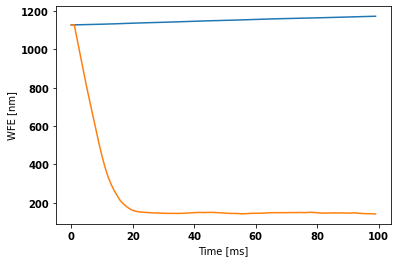

In [11]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)
